<h1> <a href = http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/td_3a.html> Eléments logiciels pour le traitement de données massives </a> </h1>
<h2> Theano : kmeans & image segmentation </h2>
<h3> ENSAE - 3A - February 2017 </h3>
<i> Students : Mehdi Miah & Duc-Vinh Tran </i> <br>
<i> Teachers : Xavier Dupré & Mathieu Durut </i>

# Table of contents
1. [Introduction](#introduction)
    1. [Kmeans algorithm](#kmeans)
    2. [Image segmentation](#imagesegmentation)
2. [Context of "small" data](#smalldata)
    1. [Generation of data](#generationdata)
    2. [Test with scikit-learn](#smallsklearn)
    3. [Test with numpy](#smallnumpy)
    4. [Test with Theano](#smalltheano)
        2.D.a. [On CPU](#smalltheano_cpu)
        2.D.b. [On GPU](#smalltheano_gpu)
3. [Context of "big" data](#bigdata)
    1. [Loading an image](#loadingimage)
    2. [Test with scikit-learn](#bigsklearn)
    3. [Test with numpy](#bignumpy)
    4. [Test with Theano](#bigtheano)
        3.D.a. [On CPU](#bigtheano_cpu)
        3.D.b. [On GPU](#bigtheano_gpu)
4. [Conclusion](#conclusion)

# 1 - Introduction <a name="introduction"></a>

In [1]:
# Some parameters we will keep in a context of small data

n_points = 40000 #number of points by clusters(in a plan)
n_clusters = 3 #number of clusters
max_iter = 50 #maximal number of iterations
learning_rate = 0.0001 #learning rate in gradient descent
batch_size = 200 #batch size use to accelerate convergence
epsilon = 0.0001 #iterations will be stopped when the cost functions does not change by 0.01%

## 1.A - Kmeans algorithm <a name="kmeans"></a>

 ## 1.B - Image segmentation <a name="imagesegmentation"></a>

# 2 - Context of "small" data <a name="smalldata"></a>

## 2.A - Generation of data <a name="generationdata"></a>

In [2]:
import numpy as np
import random
import time
from math import sqrt
from matplotlib import pyplot as plt
%matplotlib inline  

from timeit import default_timer as timer

import scipy
from scipy import spatial as sp

In [3]:
def generate_mixture(n_points):
    ''' Generate a dataset with 2D n_points as a mixture of 3 gaussians'''
    data = np.concatenate([np.random.multivariate_normal([-8,-4], [[1, 0.01], [0.01, 1]], n_points),
                        np.random.multivariate_normal([10,7], [[1, 0.01], [0.01, 1]], n_points), 
                        np.random.multivariate_normal([4,-2], [[1, 0.01], [0.01, 1]], n_points)])
    return(data)

In [4]:
data = generate_mixture(n_points)

centers1 = np.array([data[i, :] for i in random.sample(range(np.shape(data)[0]), 1)])
centers2 = np.array([data[i, :] for i in random.sample(range(np.shape(data)[0]), 1)])
centers3 = np.array([data[i, :] for i in random.sample(range(np.shape(data)[0]), 1)])

## 2.B - Test with numpy <a name="smallnumpy"></a>

In [5]:
def kmeans_numpy(X, n_clusters, max_iter=100, epsilon = 0.01):
    # Initialize from random points.
    centers = np.array([X[i, :] for i in random.sample(range(np.shape(X)[0]), n_clusters)])
    clusters = [None] * np.shape(X)[0]
    old_centers = np.array([X[i, :] for i in random.sample(range(np.shape(X)[0]), n_clusters)]) #beware !
    ''' Beware : a better initialization ?'''
    
    n_iter = 1
 
    while (n_iter <= max_iter) & (np.linalg.norm(centers - old_centers) > epsilon):
        for i, x in enumerate(X):
            clusters[i] = min(range(n_clusters), key=lambda j: np.linalg.norm(np.array(x) - np.array(centers[j])))
        
        for j, c in enumerate(centers):
            members = [x for i, x in enumerate(X) if clusters[i] == j]
            old_centers = centers.copy()
            centers[j] = np.mean(members, axis = 0) #update the centers from the elements of each cluster
            
        n_iter += 1    
    return clusters, np.array(centers), n_iter


In [6]:
def getClusters_id(dataSet,centroids,k):
    """
    Returns an array of scalars (1:k) of dimension nb_points.
    """
    clusters= [None]*np.shape(dataSet)[0] #np.zeros((1,np.shape(dataSet)[1]))
    for i,x in enumerate(dataSet):
        clusters[i] = min(range(k), key=lambda j: np.sqrt(((dataSet[i]-centroids[j])**2).sum(axis=0)))
    return clusters

Kmeans with 40000 points and 3 clusters with 3 iterations on CPU in 5.484382 s


(-5, 15)

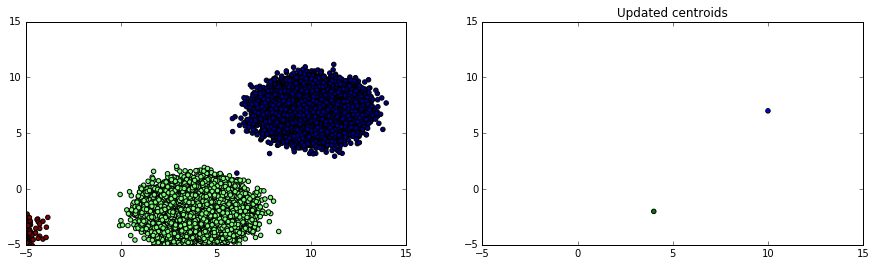

In [7]:
start = timer()
clusters, centers, n_iter = kmeans_numpy(data, n_clusters, max_iter, 0.1)
dt = timer() - start
print("Kmeans with %.0f points and %.0f clusters with %.0f iterations on CPU in %f s" % (n_points, n_clusters, n_iter-1, dt))

plt.figure(figsize=(15.0, 4.0))

plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], c = clusters)
plt.xlim([-5, 15])
plt.ylim([-5, 15])

plt.subplot(1, 2, 2)
plt.title('Updated centroids')
plt.scatter(centers[:, 0], centers[:, 1], c = 'bgr')
plt.xlim([-5, 15])
plt.ylim([-5, 15])


## 2.C - Test with Theano <a name="smalltheano"></a>

### 2.C.a - on CPU <a name="smalltheano_cpu"></a>

In [8]:
import theano
from theano import tensor as T
from theano import function, config, shared, sandbox, Out

Using gpu device 0: GeForce GT 750M (CNMeM is disabled, cuDNN not available)


In [9]:
def kmeans_theano(data, n_clusters, learning_rate, max_iter, batch_size, epsilon, verbose = False):   
    
    # == Dimensions of the problem ==========
    n_points, n_dim = data.shape
    
    # == Kmeans in Theano environment ==========
    # Theano variables
    Z = T.dmatrix('Z') #represents the data, size n_points x n_dim
    W = T.dmatrix('W') #represents the clusters in one-hot representation, size n_points x n_dim
    
    # Initilize random <n_clusters> centroids in a <n_dim> space
    centroids = theano.shared(np.random.randn(n_clusters, n_dim), name="centroids")
       
    # Function giving the new clusters
    clusters = T.argmin(
        T.sum(centroids**2, axis=1,keepdims=True) + T.sum(Z**2,axis=1, keepdims=True).T - 2*T.dot(centroids, Z.T), 
        axis = 0)
    
    # Function giving the new controids
    distances = T.dot(W.T, Z) - T.mul(T.sum(W,axis = 0)[:,None], centroids)
    errors = T.sum(T.square(distances))
    update = [(centroids, centroids + learning_rate * distances)]
    
    # == Use of theano.function to create parallelized functions ==========
    update_clusters = theano.function([Z], clusters, mode="FAST_RUN")
    update_centroids = theano.function(inputs = [Z,W], outputs = errors, updates = update, mode="FAST_RUN")
       
    # == Kmeans with the real data ==========
    #vector to keep the cost function with regards to iterations
    vect_costs = []
    old_cost = 2
    new_cost = 1
    
    n_iter = 0
    while((n_iter < max_iter) and ((epsilon < np.abs(old_cost - new_cost)/old_cost) or (n_iter < 2))):

        old_cost = new_cost
        
        for i in range(0, n_points, batch_size):
            
            #Update the clusters
            clusters = update_clusters(data[i:i+batch_size, :])

            clusters_one_hot = np.zeros([batch_size,n_clusters])
            clusters_one_hot[range(batch_size),clusters] = 1 # we put 1 at position (i,j) if the the i-th point 
                                                             # belongs to the cluster j

            #Update the centroids
            cost = update_centroids(data[i:i+batch_size, :], clusters_one_hot)
        
        if (n_iter % 10) == 0 and verbose:
            print("Iteration %.0f with a cost function at %.3f" %(n_iter, np.sum(cost)))
        
        new_cost = np.sum(cost)
        vect_costs.append(new_cost) #keep the cost 
        n_iter += 1    

    return centroids.get_value(), vect_costs

In [10]:
start_time = time.time()
# number of points must be a multiple of batch size otherwise won't work
centroids_theano, costs_theano = kmeans_theano(data, n_clusters, learning_rate, max_iter,
                                               batch_size, epsilon, verbose = False)
end_time = time.time()

Kmeans with Theano : 0.615s with a final cost at 439.443.


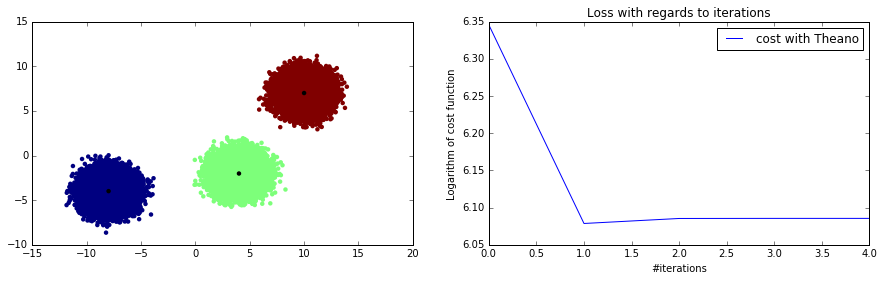

In [11]:
print("Kmeans with Theano : %.3fs with a final cost at %.3f." %(end_time - start_time, costs_theano[-1]))

plt.figure(figsize=(15.0, 4.0))

plt.subplot(1, 2, 1)
plt.scatter(data[:,0], data[:,1], c=getClusters_id(data,centroids_theano,3), edgecolor='none')
plt.scatter(centroids_theano[:,0],centroids_theano[:,1],c='black',s=20,edgecolor='none')

plt.subplot(1, 2, 2)
plt.ylabel('Logarithm of cost function')
plt.xlabel('#iterations')
plt.plot(np.log(costs_theano), c = "b", label= 'cost with Theano')
plt.legend()
plt.title('Loss with regards to iterations')

### 2.C.b - on GPU <a name="smalltheano_gpu"></a>

In [12]:
def kmeans_theano_gpu(data, n_clusters, learning_rate, max_iter, batch_size, epsilon, verbose = False):   
    
    # == Dimensions of the problem ==========
    n_points, n_dim = data.shape
    
    # == Kmeans in Theano environment ==========
    # Theano variable
    Z = T.fmatrix('Z') #represents the data, size n_points x n_dim
    W = T.fmatrix('W') #represents the clusters in one-hot representation, size n_points x n_dim
    
    # Initilize random <n_clusters> centroids in a <n_dim> space
    np.random.seed(42)
    centroids = theano.shared(np.random.randn(n_clusters, n_dim).astype(theano.config.floatX), name="centroids")
       
    # Function giving the new clusters
    clusters = T.argmin(
        T.sum(centroids**2, axis=1,keepdims=True) + T.sum(Z**2,axis=1, keepdims=True).T - 2*T.dot(centroids, Z.T), 
        axis = 0)
    
    # Function giving the new controids
    distances = T.dot(W.T, Z) - T.mul(T.sum(W,axis = 0)[:,None], centroids)
    errors = T.sum(T.square(distances))
    update = [(centroids, centroids + learning_rate * distances)]
    
    # == Use of theano.function to create parallelized functions ==========
    update_clusters = theano.function([Z], clusters, mode="FAST_RUN",allow_input_downcast=True)
    update_centroids = theano.function(inputs = [Z,W], outputs = errors, updates = update,
                                       allow_input_downcast=True,mode="FAST_RUN")
    
    #check if GPU usage
    if np.any([isinstance(x.op, T.Elemwise) for x in update_clusters.maker.fgraph.toposort()]):
        print('Used the CPU')
    else:
        print('Used the GPU')   
        
    # == Kmeans with the real data ==========
    #vector to keep the cost function with regards to iterations
    vect_costs = []
    old_cost = 2
    new_cost = 1
    
    n_iter = 0
    while((n_iter < max_iter) and ((epsilon < np.abs(old_cost - new_cost)/old_cost) or (n_iter < 2))):

        old_cost = new_cost
        
        for i in range(0, n_points, batch_size):
            
            #Update the clusters
            clusters = update_clusters(data[i:i+batch_size, :])

            clusters_one_hot = np.zeros([batch_size,n_clusters])
            clusters_one_hot[range(batch_size),clusters] = 1 # we put 1 at position (i,j) if the the i-th point 
                                                             # belongs to the cluster j

            #Update the centroids
            cost = update_centroids(data[i:i+batch_size, :], clusters_one_hot)
        
        if (n_iter % 10) == 0 and verbose:
            print("Iteration %.0f with a cost function at %.3f" %(n_iter, np.sum(cost)))
        
        new_cost = np.sum(cost)
        vect_costs.append(new_cost) #keep the cost 
        n_iter += 1    

    return centroids.get_value(), vect_costs

In [13]:
start_time = time.time()
# number of points must be a multiple of batch size otherwise won't work
centroids_theano, costs_theano = kmeans_theano_gpu(data, n_clusters, learning_rate, max_iter,
                                               batch_size, epsilon, verbose = False)
end_time = time.time()

Used the GPU


Kmeans with Theano : 1.186s with a final cost at 439.445.


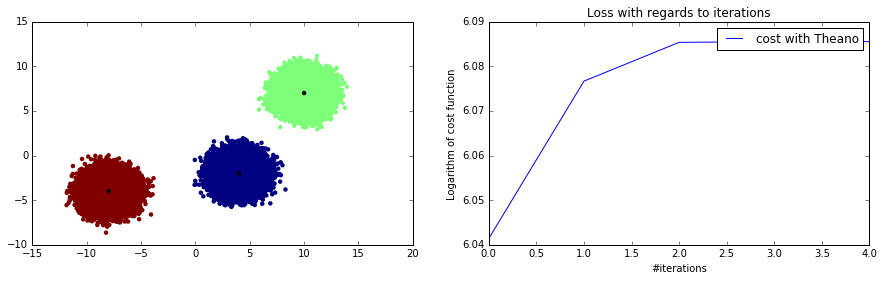

In [14]:
print("Kmeans with Theano : %.3fs with a final cost at %.3f." %(end_time - start_time, costs_theano[-1]))

plt.figure(figsize=(15.0, 4.0))

plt.subplot(1, 2, 1)
plt.scatter(data[:,0], data[:,1], c=getClusters_id(data,centroids_theano,3), edgecolor='none')
plt.scatter(centroids_theano[:,0],centroids_theano[:,1],c='black',s=20,edgecolor='none')

plt.subplot(1, 2, 2)
plt.ylabel('Logarithm of cost function')
plt.xlabel('#iterations')
plt.plot(np.log(costs_theano), c = "b", label= 'cost with Theano')
plt.legend()
plt.title('Loss with regards to iterations')

In [15]:
def kmeans_theano_gpu2(data, n_clusters, learning_rate, max_iter, batch_size, epsilon, verbose = False):   
    
    # == Dimensions of the problem ==========
    n_points, n_dim = data.shape
    
    # == Kmeans in Theano environment ==========
    # Theano variable
    Z = T.fmatrix('Z') #represents the data, size n_points x n_dim
    W = T.fmatrix('W') #represents the clusters in one-hot representation, size n_points x n_dim
    
    # Initilize random <n_clusters> centroids in a <n_dim> space
    np.random.seed(42)
    centroids = theano.shared(np.random.randn(n_clusters, n_dim).astype(theano.config.floatX),
                              borrow=True, name="centroids")
       
    # Function giving the new clusters
    clusters = T.argmin(
        T.sum(centroids**2, axis=1,keepdims=True) + T.sum(Z**2,axis=1, keepdims=True).T - 2.*T.dot(centroids, Z.T), 
        axis = 0)
    
    # Function giving the new controids
    distances = T.dot(W.T, Z) - T.mul(T.sum(W,axis = 0)[:,None], centroids)
    errors = T.sum(T.square(distances))
    update = [(centroids, centroids + learning_rate * distances)]
    
    # == Use of theano.function to create parallelized functions ==========
    update_clusters = theano.function([Z],
                                      outputs = clusters,
                                      mode="FAST_RUN",allow_input_downcast=True)
    update_centroids = theano.function(inputs = [Z,W],
                                       outputs = Out(sandbox.cuda.basic_ops.gpu_from_host(errors),borrow=True),
                                       updates = update,
                                       allow_input_downcast=True,mode="FAST_RUN")
    
    #check if GPU usage
    if np.any([isinstance(x.op, T.Elemwise) for x in update_clusters.maker.fgraph.toposort()]):
        print('Used the CPU')
    else:
        print('Used the GPU')   
        
    # == Kmeans with the real data ==========
    #vector to keep the cost function with regards to iterations
    vect_costs = []
    old_cost = 2
    new_cost = 1
    
    n_iter = 0
    while((n_iter < max_iter) and ((epsilon < np.abs(old_cost - new_cost)/old_cost) or (n_iter < 2))):

        old_cost = new_cost
        
        for i in range(0, n_points, batch_size):
            
            #Update the clusters
            clusters = update_clusters(data[i:i+batch_size, :])

            clusters_one_hot = np.zeros([batch_size,n_clusters])
            clusters_one_hot[range(batch_size),clusters] = 1 # we put 1 at position (i,j) if the the i-th point 
                                                             # belongs to the cluster j

            #Update the centroids
            cost = update_centroids(data[i:i+batch_size, :], clusters_one_hot)
        
        if (n_iter % 10) == 0 and verbose:
            print("Iteration %.0f with a cost function at %.3f" %(n_iter, np.sum(cost)))
        
        new_cost = np.sum(cost)
        vect_costs.append(new_cost) #keep the cost 
        n_iter += 1    

    return centroids.get_value(), vect_costs

In [16]:
start_time = time.time()
# number of points must be a multiple of batch size otherwise won't work
centroids_theano, costs_theano = kmeans_theano_gpu2(data, n_clusters, learning_rate, max_iter,
                                               batch_size, epsilon, verbose = False)
end_time = time.time()

Used the GPU


Kmeans with Theano : 0.865s with a final cost at 439.445.


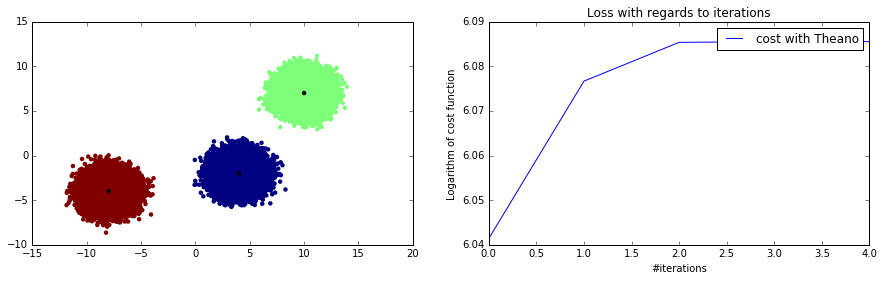

In [17]:
print("Kmeans with Theano : %.3fs with a final cost at %.3f." %(end_time - start_time, costs_theano[-1]))

plt.figure(figsize=(15.0, 4.0))

plt.subplot(1, 2, 1)
plt.scatter(data[:,0], data[:,1], c=getClusters_id(data,centroids_theano,3), edgecolor='none')
plt.scatter(centroids_theano[:,0],centroids_theano[:,1],c='black',s=20,edgecolor='none')

plt.subplot(1, 2, 2)
plt.ylabel('Logarithm of cost function')
plt.xlabel('#iterations')
plt.plot(np.log(costs_theano), c = "b", label= 'cost with Theano')
plt.legend()
plt.title('Loss with regards to iterations')

# 3 - Context of "big" Data <a name="bigdata"></a>

## 3.A - Loading an image <a name="loadingimage"></a>

Image size : [121500000, 3]


/home/duc-vinh/anaconda2/lib/python2.7/site-packages/PIL/Image.py:2192: DecompressionBombWarning: Image size (121500000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


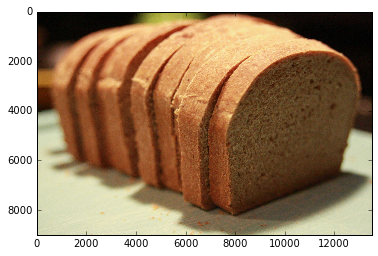

In [18]:
image = scipy.misc.imread('../data/images/huge.jpg')
plt.imshow(image) # showing the image
red, green, blue = image[:,:,0], image[:,:,1], image[:,:,2] # splitting up to channels
w, h = image[:,:,:3].shape[0], image[:,:,:3].shape[1] # remember original width and height
my_image = np.column_stack([red.flatten(),    # creating a w*h by 3 matrix for training
                        green.flatten(),
                        blue.flatten()])
print('Image size : %s' %(list(np.shape(my_image))) )

In [25]:
def getLabels(dataSet, centroids):
    """
    Returns a label for each piece of data in the dataset.
    For each element in the dataset, chose the closest centroid. 
    Make that centroid the element's label.
    This is the function which takes the most time.
    """
    #method which avoids loops with scipy cdist function
    #dist_mat=cydist(dataSet,centroids)
    dist_mat=sp.distance.cdist(dataSet,centroids,metric="euclidean")
    min_idx=dist_mat.argmin(axis=1) #vector of minimum index for each row
    mat=centroids[min_idx]
    return mat

def cydist(a, b):
    dims = a.shape[1]
    rows = a.shape[0]
    cols = b.shape[0]
    out = np.zeros((rows,cols)) 
    for dim in range(dims):
        out += np.subtract.outer(a[:,dim], b[:,dim])**2
    return out

## 3.B - Test with numpy <a name="bignumpy"></a>

## 3.C - Test with Theano <a name="bigtheano"></a>

### 3.D.a. Theano on CPU <a name="bigtheano_cpu"></a>

** Warning batch size must be able to divide the number of points**

In [ ]:
%%time
from sklearn.cluster import KMeans
clf = KMeans(n_clusters=6, precompute_distances=True, n_jobs=-1) #sur 16 coeurs
labels = clf.fit_predict(my_image)

---------

In [24]:
%%time
centroids_theano, costs_theano = kmeans_theano(my_image,6,learning_rate = 0.0001, max_iter=100, 
                                               batch_size=9000, verbose=False, epsilon = 0.01)
#alpha must be really small for good results epsilon = 0.0001

CPU times: user 35.2 s, sys: 100 ms, total: 35.3 s
Wall time: 35.6 s


In [26]:
segmented=getLabels(my_image,centroids_theano).astype(np.uint8)
reconstruct = np.array(segmented).reshape((w,h, 3))
plt.imshow(reconstruct)

MemoryError: 

### 3.D.b. Theano on GPU <a name="bigtheano_gpu"></a>

In [22]:
%%time
centroids_theano, costs_theano = kmeans_theano_gpu(my_image,6,learning_rate = 0.0001, max_iter=100, 
                                               batch_size=9000, verbose=False, epsilon = 0.01)
#alpha must be really small for good results epsilon = 0.0001

Used the GPU
CPU times: user 1min 2s, sys: 15.5 s, total: 1min 17s
Wall time: 1min 18s


In [ ]:
segmented=getLabels(my_image,centroids_theano).astype(np.uint8)
reconstruct = np.array(segmented).reshape((w,h, 3))
plt.imshow(reconstruct)

In [23]:
%%time
centroids_theano, costs_theano = kmeans_theano_gpu2(my_image,6,learning_rate = 0.0001, max_iter=100, 
                                               batch_size=9000, verbose=False, epsilon = 0.01)
#alpha must be really small for good results epsilon = 0.0001

Used the GPU
CPU times: user 59.5 s, sys: 15.5 s, total: 1min 14s
Wall time: 1min 14s


In [ ]:
segmented=getLabels(my_image,centroids_theano).astype(np.uint8)
reconstruct = np.array(segmented).reshape((w,h, 3))
plt.imshow(reconstruct)

# 4 - Conclusion <a name="conclusion"></a>

### Version Ergodol

In [ ]:
import theano
import theano.tensor as T
from theano import function, config, shared, sandbox
from theano import ProfileMode
import warnings
warnings.filterwarnings("ignore")

# Dummy Data

def create_dummy_data( N=4000, feats=784):
    rng = np.random
    DATA = rng.randn(N, feats)
    DATA = np.random.randn(N, feats)
    return DATA

def klp_kmeans(data, cluster_num, alpha, epochs = -1, batch = 1, verbose = False, use_gpu=False):   
	'''
		Theano based implementation, likely to use GPU as well with required Theano
		configurations. Refer to http://deeplearning.net/software/theano/tutorial/using_gpu.html
		for GPU settings
		Inputs:
			data - [instances x variables] matrix of the data.
			cluster_num - number of requisite clusters 
			alpha - learning rate 
			epoch - how many epoch you want to go on clustering. If not given, it is set with
				Kohonen's suggestion 500 * #instances
			batch - batch size. Larger batch size is better for Theano and GPU utilization 
			verbose - True if you want to verbose the algorithm's iterations
		Output:
			W - final cluster centroids
	'''
	if use_gpu:
		config.floatX = 'float32' # Theano needs this type of data for GPU use

	warnings.simplefilter("ignore", DeprecationWarning)
	warnings.filterwarnings("ignore")

	rng = np.random
    # From Kohonen's paper
	if epochs == -1:
	    print( data.shape[0])
	    epochs = 500 * data.shape[0]

	
	if use_gpu == False:
		# Symmbol variables
		X = T.dmatrix('X')
		WIN = T.dmatrix('WIN')

		# Init weights random
		W = theano.shared(rng.randn(cluster_num, data.shape[1]), name="W")
	else:
		# for GPU use 
		X = T.matrix('X')
		WIN = T.matrix('WIN')
		W = theano.shared(rng.randn(cluster_num, data.shape[1]).astype(theano.config.floatX), name="W")

	W_old = W.get_value()

	# Find winner unit
	bmu = ((W**2).sum(axis=1, keepdims=True) + (X**2).sum(axis=1, keepdims=True).T - 2*T.dot(W, X.T)).argmin(axis=0)
	dist = T.dot(WIN.T, X) - WIN.sum(0)[:, None] * W
	err = abs(dist).sum()/X.shape[0]

	update = function([X,WIN],outputs=err,updates=[(W, W + alpha * dist)], allow_input_downcast=True)
	find_bmu = function([X], bmu, allow_input_downcast=True)

	if any([x.op.__class__.__name__ in ['Gemv', 'CGemv', 'Gemm', 'CGemm'] for x in
	        update.maker.fgraph.toposort()]):
	    print( 'Used the cpu')
	elif any([x.op.__class__.__name__ in ['GpuGemm', 'GpuGemv'] for x in
	        update.maker.fgraph.toposort()]):
	    print( 'Used the gpu')
	else:
	    print( 'ERROR, not able to tell if theano used the cpu or the gpu')
	    print( update.maker.fgraph.toposort())
    
    
	# Update
	for epoch in range(epochs):
	    C = 0
	    for i in range(0, data.shape[0], batch):
	        batch_data = data[i:i+batch, :]
	        D = find_bmu(batch_data)
	        # for GPU use 
	        if use_gpu:
	        	S = np.zeros([batch,cluster_num], config.floatX)
	        else:
	        	S = np.zeros([batch_data.shape[0],cluster_num])
	        S[:,D] = 1
	        cost = update(batch_data, S)
	        
	    if epoch%10 == 0 and verbose:
	        print( "Avg. centroid distance -- ", cost.sum(),"\t EPOCH : ", epoch)
	return W.get_value()

In [ ]:
#Test sur les données simulées
%time W=klp_kmeans(data, 3, alpha = 0.00001, epochs = 100, batch = 2000, verbose = False, use_gpu=True)

In [ ]:
plt.figure(num=None, figsize=(12,12), dpi=100, facecolor='w', edgecolor='k')
plt.scatter(data[:,0], data[:,1],c=getClusters_id(data,W,3),s=90)

In [ ]:
%time W= klp_kmeans(data, 3, alpha = 0.0001, epochs = 100, batch = 2000, verbose = False, use_gpu=False)

In [ ]:
plt.figure(num=None, figsize=(12,12), dpi=100, facecolor='w', edgecolor='k')
plt.scatter(data[:,0], data[:,1],c=getClusters_id(data,W,3),s=90)